Example test code for estimating essential matrix from SIFT correspondences

In [7]:
# If you use this code, please cite the following paper.

# For the feature detection part:
# [1] Mishchuk, Anastasiia, et al. "Working hard to know your neighbor's margins: Local descriptor learning loss." Advances in neural information processing systems 30 (2017).
# [2] Mishkin, Dmytro, Filip Radenovic, and Jiri Matas. "Repeatability is not enough: Learning affine regions via discriminability." Proceedings of the European Conference on Computer Vision (ECCV). 2018.

# For the robust estimation part:
# [3] Barath, Daniel, and Jiří Matas. "Graph-cut RANSAC." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.
# [4] Barath, Daniel, and Zuzana Kukelova. "Relative Pose from SIFT Features." arXiv preprint arXiv:2203.07930 (2022).
# [5] Barath, Daniel, and Zuzana Kukelova. "Homography from two orientation-and scale-covariant features." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2019.

# For the sampler used inside the robust estimation:
# If sampler_id == 1 (PROSAC)
# [6] Chum, Ondrej, and Jiri Matas. "Matching with PROSAC-progressive sample consensus." 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05). Vol. 1. IEEE, 2005.
# If sampler_id == 2 (Progressive-NAPSAC)
# [7] Barath, Daniel, et al. "MAGSAC++, a fast, reliable and accurate robust estimator." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020.
# If sampler_id == 3 (NG-RANSAC's sampler)
# [8] Brachmann, Eric, and Carsten Rother. "Neural-guided RANSAC: Learning where to sample model hypotheses." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2019.
# If sampler_id == 4 (AR-Sampler sampler)
# [9] Tong, Wei, Jiri Matas, and Daniel Barath. "Deep MAGSAC++." arXiv preprint arXiv:2111.14093 (2021).

# Thanks!

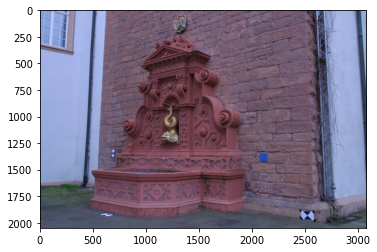

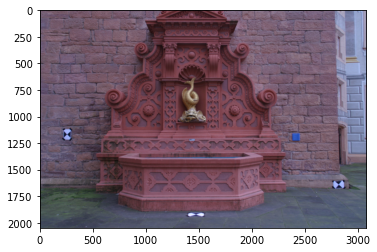

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pygcransac
from time import time
from gcransac_parameter_types import *

img1 = cv2.cvtColor(cv2.imread('../build/data/fountain/fountain1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/fountain/fountain2.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

# Loading the intrinsic camera matrices
K1 = np.loadtxt('../build/data/fountain/fountain1.K')
K2 = np.loadtxt('../build/data/fountain/fountain2.K')

In [9]:
#We will detect ORB features and match them with cross-check test
det = cv2.SIFT_create(8000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher()

SNN_threshold = 0.90
matches = bf.knnMatch(descs1, descs2, k = 2)

# Apply ratio test
snn_ratios = []
tentatives = []
for m, n in matches:
    if m.distance < SNN_threshold * n.distance:
        tentatives.append(m)
        snn_ratios.append(m.distance / n.distance)

sorted_indices = np.argsort(snn_ratios)
tentatives = list(np.array(tentatives)[sorted_indices])

print(f"{len(tentatives)} tentative correspondences are found.")

1176 tentative correspondences are found.


In [10]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [11]:
# A function to convert the point ordering to probabilities used in NG-RANSAC's sampler or AR-Sampler.
def get_probabilities(tentatives):
    probabilities = []
    # Since the correspondences are assumed to be ordered by their SNN ratio a priori,
    # we just assign a probability according to their order.
    for i in range(len(tentatives)):
        probabilities.append(1.0 - i / len(tentatives))
    return probabilities

# A function to convert pairs of LAFs to affine correspondences (ACs)
def get_sift_correspondences(kps1, kps2, tentatives):
    # Initialize the ACs
    SIFTs = np.zeros((len(tentatives), 8))
    row = 0
    # Iterate through all tentative correspondences and them to the matrix
    for m in tentatives:
        # The LAF in the source image
        SIFT1 = kps1[m.queryIdx]
        # The LAF in the destination image
        SIFT2 = kps2[m.trainIdx]

        # Saving the coordinates in the ACs matrix
        SIFTs[row, 0] = SIFT1.pt[0]
        SIFTs[row, 1] = SIFT1.pt[1]
        SIFTs[row, 2] = SIFT2.pt[0]
        SIFTs[row, 3] = SIFT2.pt[1]
        SIFTs[row, 4] = SIFT1.size
        SIFTs[row, 5] = SIFT2.size
        SIFTs[row, 6] = SIFT1.angle / 180.0 * np.pi
        SIFTs[row, 7] = SIFT2.angle / 180.0 * np.pi
        row += 1

    return np.float32(SIFTs)
    
# A function to run OpenCV's RANSAC on the point correspondences extracted from the affine frames
def verify_cv2_essential_matrix(kps1, kps2, tentatives, K1, K2):
    # Copy the coordinates in the source image selected by the tentative correspondences
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    # Copy the coordinates in the destination image selected by the tentative correspondences
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    # Normalize the threshold
    threshold = 0.75
    avgDiagonal = (K1[0][0] + K1[1][1] + K2[0][0] + K2[1][1]) / 4; 
    normalizedThreshold = threshold / avgDiagonal
            
    # Normalize the point coordinates
    normalizedSourcePoints = cv2.undistortPoints(np.expand_dims(src_pts, axis=1), cameraMatrix=K1, distCoeffs=None)
    normalizedDestinationPoints = cv2.undistortPoints(np.expand_dims(dst_pts, axis=1), cameraMatrix=K2, distCoeffs=None)

    # Estimate the essential matrix from the normalized coordinates
    # using the normalized threshold.
    E, mask = cv2.findEssentialMat(normalizedSourcePoints, 
                                   normalizedDestinationPoints, 
                                   focal=1.0, 
                                   pp=(0., 0.),
                                   method=cv2.RANSAC, 
                                   prob=0.99,
                                   threshold=normalizedThreshold)

    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

def verify_affine_pygcransac_essential_matrix(ACs, tentatives, h1, w1, h2, w2, K1, K2, sampler_id):
    # NG-RANSAC and AR-Sampler require an inlier probability to be provided for each point.
    # Since deep learning-based prediction is not applied here, we calculate the probabilities
    # from the SNN ratio ranks. This part can be straightforwardly replaced by a deep probability
    # predictor, e.g., NG-RANSAC, CLNet, OANet, Deep MAGSAC++.
    inlier_probabilities = []
    if sampler_id == 3 or sampler_id == 4:
        inlier_probabilities = get_probabilities(tentatives)

    # Run GC-RANSAC with the AC-based solver
    E, mask = pygcransac.findEssentialMatrix(
        np.ascontiguousarray(ACs), # The input affine correspondences
        K1, # Intrinsic camera parameters of the source image
        K2, # Intrinsic camera parameters of the destination image
        h1, w1, h2, w2, # The sizes of the input images
        threshold = 0.75, # The inlier-outlier threshold
        sampler = sampler_id, # The index of the sampler to be used. 0 - uniform, 1 - PROSAC, 2 - P-NAPSAC, 3 - NG-RANSAC's sampler, 4 - AR-Sampler
        max_iters = 5000, # The maximum number of iterations
        min_iters = 50, # The minimum number of iterations
        probabilities = inlier_probabilities, # The inlier probabilities for all points
        spatial_coherence_weight = 0.1, # The weight for the spatial coherence term. It seems this is important for ACs.
        neighborhood = 1, # Neighborhood type. 0 - grid-based (faster/less accurate), 1 - FLANN-based (slower/more accurate).
        neighborhood_size = 20, # The neighborhood size. For grid-based neighborhood, it is the division number along each axis, 8 works well. For FLANN, it is the radius of the hypersphere used.
        solver = Solver.SIFTBased.value) # The id of the used solver. 0 - point-based, 1 - SIFT-based, 2 - AC-based
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

# The time before starting the estimation with OpenCV's RANSAC
t = time()
# Running OpenCV's RANSAC for fundamental matrix estimation
cv2_F, cv2_mask = verify_cv2_essential_matrix(kps1, kps2, tentatives, K1, K2)
# Measuring the run-time
print (time()-t, 'sec cv2')

# Extracting the affine correspondence so GC-RANSAC with affine solver can run
SIFTs = get_sift_correspondences(kps1, kps2, tentatives) 

# The time before starting the estimation with OpenCV's RANSAC
t = time()
gc_F, gc_mask = verify_affine_pygcransac_essential_matrix(SIFTs, # The input affine correspondences
    tentatives, # The matches containing the indices of the matched keypoints
    img1.shape[0], # The width of the source image
    img1.shape[1], # The height of the source image
    img2.shape[0], # The width of the destination image
    img2.shape[1], # The height of the destination image
    K1, # The intrinsic parameters of the source camera
    K2, # The intrinsic parameters of the destination camera
    Sampler.ARSampler.value) # The id of the used sampler. 0 - uniform, 1 - PROSAC, 3 - NG-RANSAC's sampler, 4 - AR-Sampler
# Measuring the run-time
print (time()-t, 'sec pygcransac-sift')

537.0 inliers found
0.06072545051574707 sec cv2
606.0 inliers found
0.026433229446411133 sec pygcransac-sift


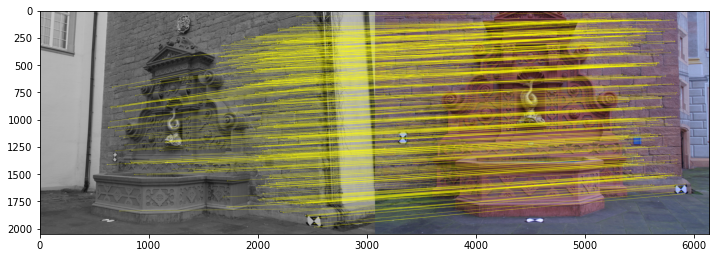

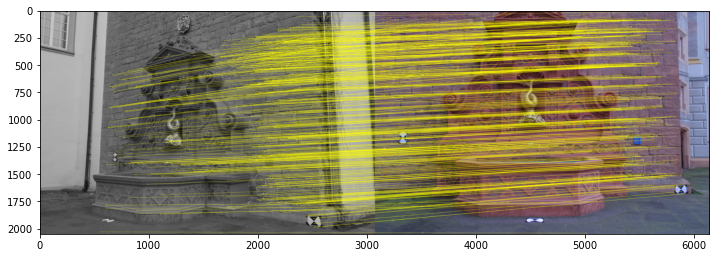

In [12]:
draw_matches(kps1, kps2, tentatives, img1, img2, cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, gc_mask.astype(np.uint8))